<a href="https://colab.research.google.com/github/j-thapaliya/NLP/blob/main/Vanilla_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import nltk
import string as s
import re
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from datasets import load_dataset

from sklearn.feature_extraction.text  import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics  import f1_score,accuracy_score
from sklearn.metrics import  confusion_matrix
from sklearn.svm import LinearSVC

In [ ]:
dataset = load_dataset("ag_news")  # train/test split (120k train, 7600 test)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [ ]:
df_train = dataset["train"].to_pandas()
df_test = dataset["test"].to_pandas()

In [ ]:
df_train.sample(5)

,text,label
27417,Larsson on bench at Parkhead Barcelona coach F...,1
17294,UN vote due on Syria resolution The UN Securit...,0
52366,Astros Take Game 1 Roger Clemens wins his nint...,1
108073,China Landslide Leaves 65 Villagers Missing - ...,0
89844,"West Virginia Mountaineers MORGANTOWN, West Vi...",1


In [ ]:
df_test.sample(5)

,text,label
4161,Children #39;s Place to buy Disney stores In e...,2
6839,MPs back Putin plan for regions The Russian Du...,0
4549,"Australia 362-7 v India, third test - close (R...",0
5504,FTSE dips as insurers fall Blue-chip shares ha...,2
697,Taiwan Rescuers Dig Out 7 Bodies Buried in Lan...,0


In [ ]:
print(df_train.shape)
print(df_test.shape)

(120000, 2)
(7600, 2)


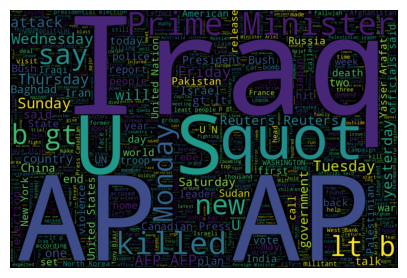

In [ ]:
world = df_train[df_train['label']== 0]['text']
plt.figure(figsize=(5, 5))
wordcloud = WordCloud(min_font_size=3, max_words=2500, width=1200, height=800).generate(" ".join(world))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

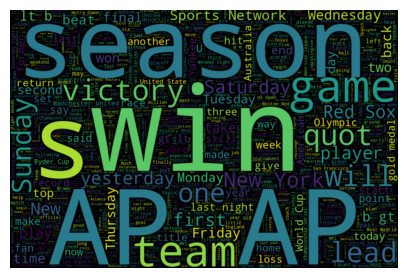

In [ ]:
sports = df_train[df_train['label']== 1]['text']
plt.figure(figsize=(5, 5))
wordcloud = WordCloud(min_font_size=3, max_words=2500, width=1200, height=800).generate(" ".join(sports))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

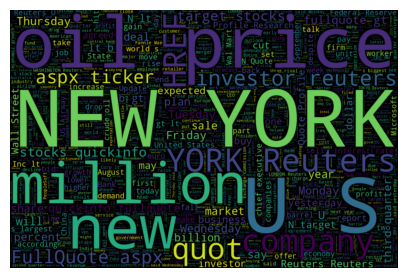

In [ ]:
business = df_train[df_train['label']== 2]['text']
plt.figure(figsize=(5, 5))
wordcloud = WordCloud(min_font_size=3, max_words=2500, width=1200, height=800).generate(" ".join(business))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

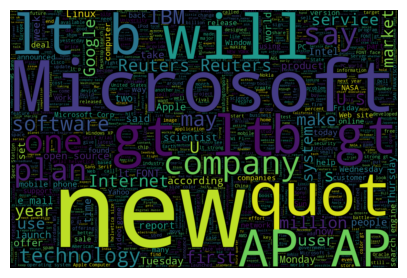

In [ ]:
science = df_train[df_train['label']== 3]['text']
plt.figure(figsize=(5, 5))
wordcloud = WordCloud(min_font_size=3, max_words=2500, width=1200, height=800).generate(" ".join(science))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
#Removing tags
def remove_html_tag(text):
    html = re.compile('<.*?')
    cleaned_text = html.sub('', text)
    return cleaned_text

#Revoming URL
def url_remove(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

In [ ]:
#Data for classification
train_x = df_train['text']
train_y = df_train['label']
test_x = df_test['text']
test_y = df_test['label']

In [ ]:
train_x = train_x.apply(remove_html_tag)
test_x = test_x.apply(remove_html_tag)
train_x = train_x.apply(url_remove)
test_x = test_x.apply(url_remove)

In [ ]:
#Tokenization
def word_tokenize(text):
    token = re.findall(r"[\w']+", text)
    return token
train_x = train_x.apply(word_tokenize)
test_x = test_x.apply(word_tokenize)

In [ ]:
#Lowercase
train_x = train_x.apply(lambda x: [word.lower() for word in x])
test_x = test_x.apply(lambda x: [word.lower() for word in x])

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
#Remove Stopwords
def remove_stopwords(lst):
    stop_words = set(stopwords.words('english'))
    return [word for word in lst if word.lower() not in stop_words]
train_x = train_x.apply(remove_stopwords)
test_x = test_x.apply(remove_stopwords)

In [ ]:
#Remove puctuations
import string
def remove_punctuations(lst):
    return [''.join(char for char in word if char not in string.punctuation) for word in lst]
train_x = train_x.apply(remove_punctuations)
test_x = test_x.apply(remove_punctuations)

In [ ]:
#Remove numbers
def remove_number(lst):
    return [''.join(char for char in word if char not in string.digits) for word in lst if word]
train_x = train_x.apply(remove_number)
test_x = test_x.apply(remove_number)

In [ ]:
#Stemming
from nltk.stem import PorterStemmer
def stemming(text):
    porter_stemmer = PorterStemmer()
    return [porter_stemmer.stem(word) for word in text]
train_x = train_x.apply(stemming)
test_x = test_x.apply(stemming)

In [ ]:
#Join words with spaces to make the tokens back into string
def join_words_with_space(sentence):
    joined_sentence = ' '.join(sentence)
    return joined_sentence

train_x = train_x.apply(join_words_with_space)
test_x = test_x.apply(join_words_with_space)

In [ ]:
#Feature Extraction
tfidf = TfidfVectorizer(min_df=8, ngram_range=(1, 3))
train_1 = tfidf.fit_transform(train_x)
test_1 = tfidf.transform(test_x)
print("No. of features extracted:")
print(len(tfidf.vocabulary_))
print("First 100 feature names:")
print(list(tfidf.vocabulary_.keys())[:100])
train_arr = train_1.toarray()
test_arr = test_1.toarray()

No. of features extracted:
72855
First 100 feature names:
['wall', 'st', 'bear', 'claw', 'back', 'black', 'reuter', 'short', 'seller', 'street', 'dwindl', 'band', 'ultra', 'cynic', 'see', 'green', 'wall st', 'claw back', 'back black', 'reuter reuter', 'wall street', 'see green', 'carlyl', 'look', 'toward', 'commerci', 'aerospac', 'privat', 'invest', 'firm', 'group', 'reput', 'make', 'well', 'time', 'occasion', 'controversi', 'play', 'defens', 'industri', 'quietli', 'place', 'bet', 'anoth', 'part', 'market', 'reuter privat', 'privat invest', 'invest firm', 'carlyl group', 'play defens', 'place bet', 'oil', 'economi', 'cloud', 'stock', 'outlook', 'soar', 'crude', 'price', 'plu', 'worri', 'earn', 'expect', 'hang', 'next', 'week', 'depth', 'summer', 'doldrum', 'oil economi', 'outlook reuter', 'soar crude', 'crude price', 'worri economi', 'economi outlook', 'earn expect', 'hang stock', 'stock market', 'market next', 'next week', 'outlook reuter reuter', 'iraq', 'halt', 'export', 'main', 'so

In [ ]:
#Multinomial Naive Bayes
NB_MN=MultinomialNB()
NB_MN.fit(train_arr,train_y)
pred_NB=NB_MN.predict(test_arr)

print("first 20 actual labels")
print(test_y.tolist()[:20])
print("first 20 predicted labels")
print(pred_NB.tolist()[:20])

first 20 actual labels
[2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
first 20 predicted labels
[2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2]


In [ ]:
#Function for Accuracy and F1 score
def eval_model(y,y_pred):
    print("F1 score of the model")
    print(f1_score(y,y_pred,average='micro'))
    print("Accuracy of the model")
    print(accuracy_score(y,y_pred))
    print("Accuracy of the model in percentage")
    print(round(accuracy_score(y,y_pred)*100,3),"%")

In [ ]:
#Confusion matrix function
def confusion_mat(pred, color='Blues'):
    cof=confusion_matrix(test_y, pred)
    cof=pd.DataFrame(cof, index=[i for i in range(1,5)], columns=[i for i in range(1,5)])
    sns.set(font_scale=1.5)
    plt.figure(figsize=(8,8));

    sns.heatmap(cof, cmap=color,linewidths=1, annot=True,square=True, fmt='d', cbar=False,xticklabels=['World','Sports','Business','Science'],yticklabels=['World','Sports','Business','Science']);
    plt.xlabel("Predicted Classes");
    plt.ylabel("Actual Classes");

In [ ]:
eval_model(test_y,pred_NB)

a=round(accuracy_score(test_y,pred_NB)*100,3)

F1 score of the model
0.9042105263157895
Accuracy of the model
0.9042105263157895
Accuracy of the model in percentage
90.421 %


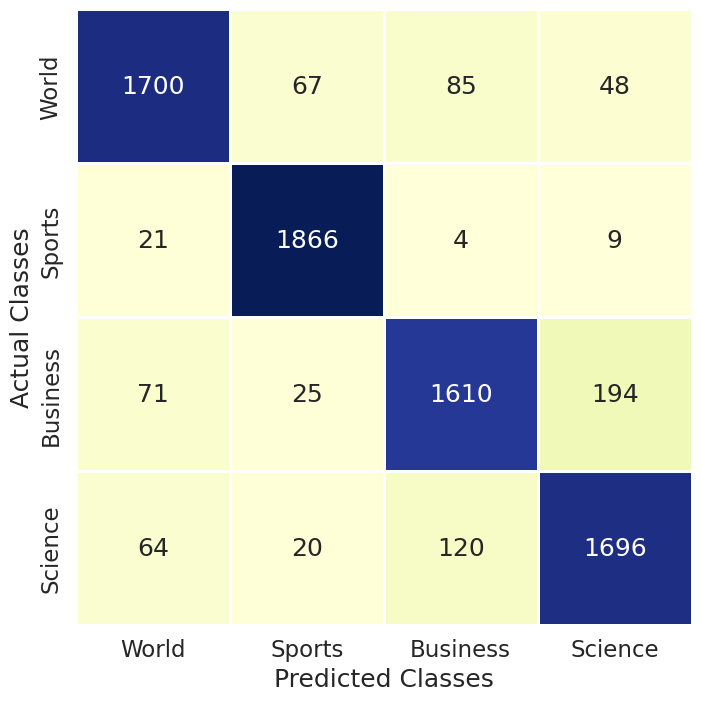

In [ ]:
confusion_mat(pred_NB, color='YlGnBu')

In [ ]:
#Linear Support Vector Machine
svm_model = LinearSVC(random_state=42, max_iter=10000)  # max_iter increased to ensure convergence
svm_model.fit(train_arr, train_y)
pred_svm = svm_model.predict(test_arr)

print("First 20 actual labels:")
print(test_y.tolist()[:20])
print("First 20 predicted labels:")
print(pred_svm.tolist()[:20])

First 20 actual labels:
[2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
First 20 predicted labels:
[2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2]


In [ ]:
eval_model(test_y,pred_svm)

b=round(accuracy_score(test_y,pred_svm)*100,3)

F1 score of the model
0.921578947368421
Accuracy of the model
0.921578947368421
Accuracy of the model in percentage
92.158 %


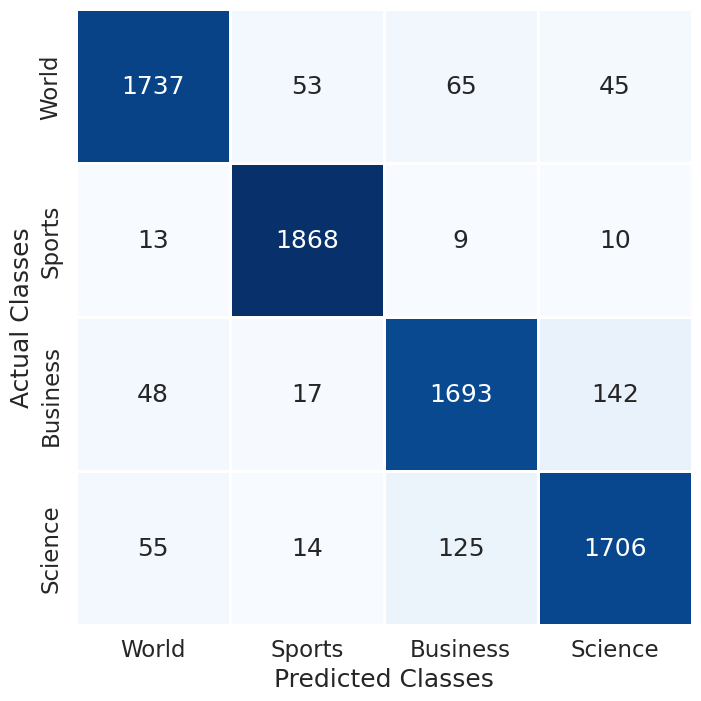

In [ ]:
confusion_mat(pred_svm, color='Blues')

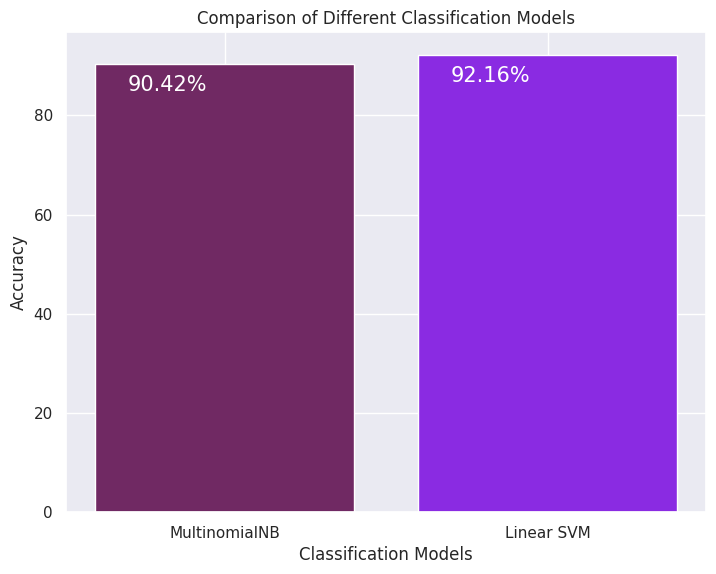

In [ ]:
#Comparision of different models
sns.set()
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
Models = ['MultinomialNB', 'Linear SVM']
Accuracy=[a,b]
ax.bar(Models,Accuracy,color=['#702963','#8a2be2']);
for i in ax.patches:
    ax.text(i.get_x()+.1, i.get_height()-5.5, str(round(i.get_height(),2))+'%', fontsize=15, color='white')
plt.title('Comparison of Different Classification Models');
plt.ylabel('Accuracy');
plt.xlabel('Classification Models');

plt.show();